In [2]:
import pandas as pd
import numpy as np
import inspect
import warnings
import matplotlib.pyplot as plt
import os
import glob
import time

from astropy.nddata import extract_array
from astropy.table import QTable
from astropy.utils import lazyproperty

from photutils.detection.core import StarFinderBase, _StarFinderKernel
from photutils.utils._convolution import _filter_data
from photutils.utils._misc import _get_version_info
from photutils.utils.exceptions import NoDetectionsWarning
from photutils.aperture import aperture_photometry, CircularAperture
from photutils.aperture import CircularAnnulus
from photutils.aperture import CircularAperture, ApertureStats
from photutils.datasets import make_4gaussians_image

import time
from matplotlib.colors import LogNorm
from IPython import display
from IPython.display import clear_output

In [3]:
#This book obtains the star counts of every star detected in each image and saves to a csv file

In [6]:
#Getting all the csv files for each star image:
image = []
image_list = glob.glob('Reduced_RV_Uma_Light_Blue*.fits')
image_list

['Reduced_RV_Uma_Light_Blue_32_secs_001.fits',
 'Reduced_RV_Uma_Light_Blue_32_secs_002.fits',
 'Reduced_RV_Uma_Light_Blue_32_secs_003.fits',
 'Reduced_RV_Uma_Light_Blue_32_secs_004.fits',
 'Reduced_RV_Uma_Light_Blue_32_secs_005.fits',
 'Reduced_RV_Uma_Light_Blue_32_secs_006.fits',
 'Reduced_RV_Uma_Light_Blue_32_secs_007.fits',
 'Reduced_RV_Uma_Light_Blue_32_secs_008.fits',
 'Reduced_RV_Uma_Light_Blue_32_secs_009.fits',
 'Reduced_RV_Uma_Light_Blue_32_secs_010.fits',
 'Reduced_RV_Uma_Light_Blue_32_secs_011.fits',
 'Reduced_RV_Uma_Light_Blue_32_secs_012.fits',
 'Reduced_RV_Uma_Light_Blue_32_secs_013.fits',
 'Reduced_RV_Uma_Light_Blue_32_secs_014.fits',
 'Reduced_RV_Uma_Light_Blue_32_secs_015.fits',
 'Reduced_RV_Uma_Light_Blue_32_secs_016.fits',
 'Reduced_RV_Uma_Light_Blue_32_secs_017.fits',
 'Reduced_RV_Uma_Light_Blue_32_secs_018.fits',
 'Reduced_RV_Uma_Light_Blue_32_secs_019.fits',
 'Reduced_RV_Uma_Light_Blue_32_secs_020.fits',
 'Reduced_RV_Uma_Light_Blue_32_secs_021.fits',
 'Reduced_RV_

In [9]:
#Loading up the first reduced file:
from astropy.io import fits
#fits_image_filename = ('Reduced_RV_Uma_Light_Blue_32_secs_055.fits')
for image in image_list:
    hdul = fits.open(image)
    hdul.info()

Filename: Reduced_RV_Uma_Light_Blue_32_secs_001.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      41   (2328, 1760)   float32   
Filename: Reduced_RV_Uma_Light_Blue_32_secs_002.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      41   (2328, 1760)   float32   
Filename: Reduced_RV_Uma_Light_Blue_32_secs_003.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      41   (2328, 1760)   float32   
Filename: Reduced_RV_Uma_Light_Blue_32_secs_004.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      41   (2328, 1760)   float32   
Filename: Reduced_RV_Uma_Light_Blue_32_secs_005.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      41   (2328, 1760)   float32   
Filename: Reduced_RV_Uma_Light_Blue_32_secs_006.fits
No.    Name      Ver    Type    

Filename: Reduced_RV_Uma_Light_Blue_32_secs_046.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      41   (2328, 1760)   float32   
Filename: Reduced_RV_Uma_Light_Blue_32_secs_047.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      41   (2328, 1760)   float32   
Filename: Reduced_RV_Uma_Light_Blue_32_secs_048.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      41   (2328, 1760)   float32   
Filename: Reduced_RV_Uma_Light_Blue_32_secs_049.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      41   (2328, 1760)   float32   
Filename: Reduced_RV_Uma_Light_Blue_32_secs_050.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      41   (2328, 1760)   float32   
Filename: Reduced_RV_Uma_Light_Blue_32_secs_051.fits
No.    Name      Ver    Type    

In [28]:
for image in image_list:
    hdul1 = fits.getdata(image)
    print(hdul1) #Shows the array of the image

[[0.9913126  1.2593195  0.8191063  ... 0.90089    1.3812749  1.4029639 ]
 [1.3304565  1.3318173  1.3984171  ... 1.1274515  1.2768856  0.74065274]
 [1.3040415  1.2879443  0.70256865 ... 0.82786906 1.0994904  1.355256  ]
 ...
 [0.36864164 1.0448354  0.54916006 ... 1.1733968  0.8699955  0.7653589 ]
 [1.0765574  0.88071764 0.8108508  ... 0.80181193 1.2587005  0.67196345]
 [0.88039595 0.79526824 0.89654833 ... 1.0698154  1.2222996  1.1293626 ]]
[[1.4203179  0.86584467 0.74794054 ... 1.3310596  1.0218087  1.1508702 ]
 [0.7990798  1.3305856  1.0434618  ... 1.1619525  1.131567   1.0366557 ]
 [0.5633029  0.68781745 1.0894125  ... 0.5381446  1.1345608  0.9945375 ]
 ...
 [0.7526768  1.1129525  1.076132   ... 1.2450397  1.1619135  0.8019194 ]
 [0.8631164  0.66979647 0.77520716 ... 1.2384841  0.67391825 0.7085698 ]
 [1.5147662  0.8981158  1.1829274  ... 1.1050875  1.004488   1.7834567 ]]
[[1.1370857  0.9359615  1.0671988  ... 1.257447   1.4517063  0.9725678 ]
 [1.3291953  1.263938   1.2220192  ... 

[[2.4895053 2.3616433 2.2767944 ... 2.0540633 1.5221971 2.1981444]
 [2.389648  2.573566  2.1433377 ... 2.0568783 2.637785  1.6115024]
 [2.2209873 2.375236  2.045506  ... 2.2642894 2.2540622 1.8999232]
 ...
 [2.365377  2.418378  1.7904172 ... 2.1838899 2.9722674 2.5513866]
 [2.3084407 2.4664986 2.0429664 ... 2.5543237 2.387899  2.1518726]
 [1.6613905 2.1746533 2.5845532 ... 2.0841553 1.8803865 2.8019338]]
[[1.8543115 2.1095436 3.029178  ... 2.1599345 2.4568644 2.7034874]
 [1.9286754 1.6881891 2.2109635 ... 2.2352903 2.0673275 1.8235543]
 [1.8715814 1.9200577 2.2835073 ... 2.5832403 1.7841449 1.4687185]
 ...
 [2.1203043 2.666717  1.7475857 ... 2.260424  1.871734  1.9669576]
 [2.6971807 2.0783525 2.2184236 ... 1.640044  2.0597308 2.4433937]
 [2.4397578 2.3501215 2.3479156 ... 2.301335  2.3533776 2.2195194]]
[[2.4141247 2.2825108 2.3825085 ... 3.0263765 2.0963962 2.195063 ]
 [2.1424859 2.5739772 2.564914  ... 2.3774464 1.9939166 2.1165154]
 [2.2224774 2.2993183 2.4341564 ... 2.297301  2.75

In [13]:
#Finding the date and time of observation:
from astropy.time import Time
for image in image_list:
    hdul2 = fits.open(image)
    date = hdul2[0].header.get('DATE-OBS')
    t = Time(date)
    t.format = 'jd'
    MJD = t - 2400000.5
    print(MJD)

C:\Users\micha\anaconda3\lib\site-packages\erfa\core.py:154: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),


59658.89826337963
59658.89990748843
59658.90156313658
59658.90318001158
59658.90481436343
59658.906386296294
59658.90797237268
59658.90951601852
59658.914283356484
59658.915925787034
59658.91751936343
59658.919177905096
59658.93207342592
59658.93366200232
59658.93523292824
59658.936833078704
59658.938493333335
59658.940077060186
59658.94167728009
59658.943267395836
59658.944912673614
59658.946494710646
59658.94810214121
59658.9496818287
59658.95131548611
59658.952885520834
59658.95446123843
59658.956056180556
59658.957715729164
59658.95929168982
59658.96086237268
59658.96676150463
59658.96840113426
59658.97001384259
59658.971697939814
59658.97336707176
59658.97500474537
59658.97665862268
59658.97832392361
59658.979968402775
59658.98160741898
59658.98324891204
59658.98492144676
59658.98905224537
59658.99063384259
59658.99221221065
59658.99378767361
59658.995366689815
59658.99693263889
59658.99851766204
59659.000085266205
59659.00167460648
59659.00326668981
59659.00482324074
59659.006392

C:\Users\micha\AppData\Local\Temp\ipykernel_11832\3553949728.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


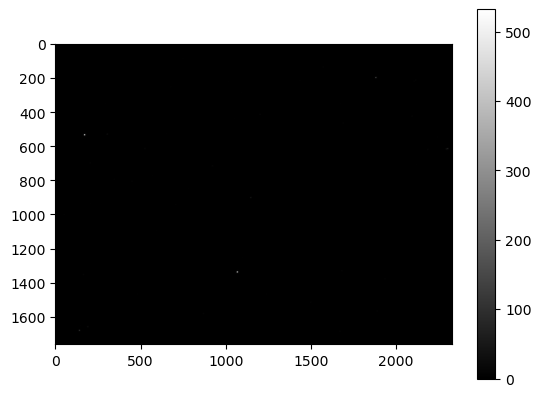

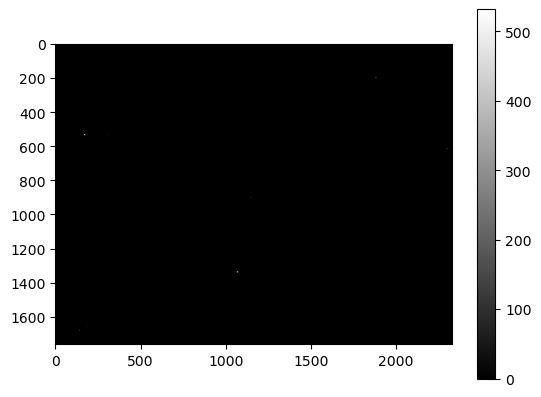

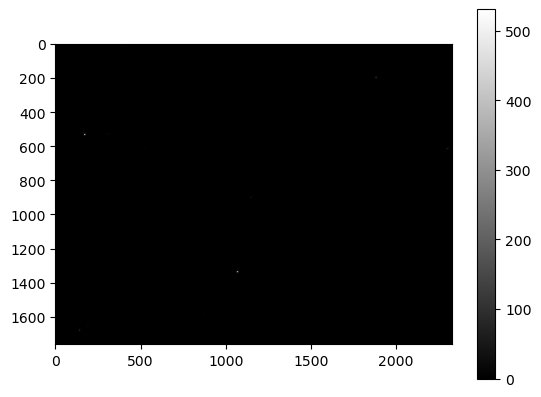

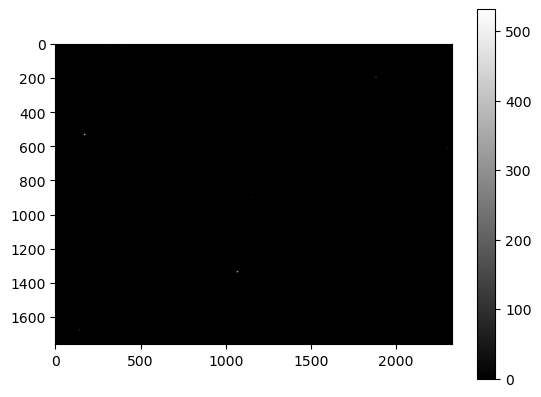

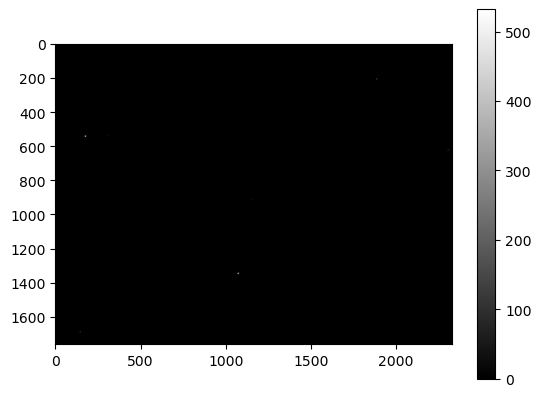

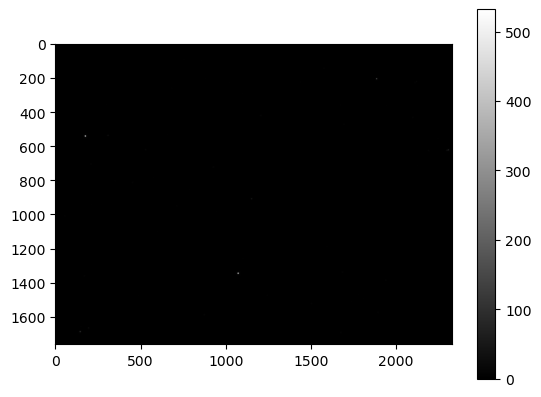

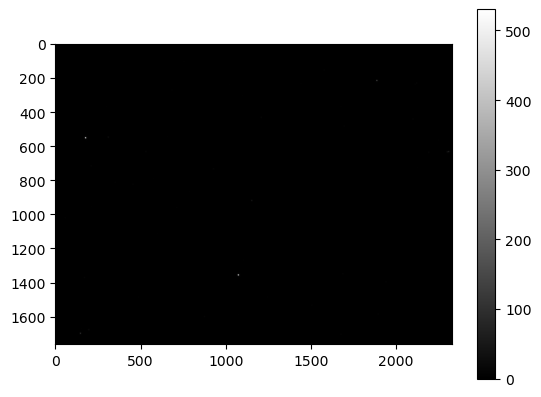

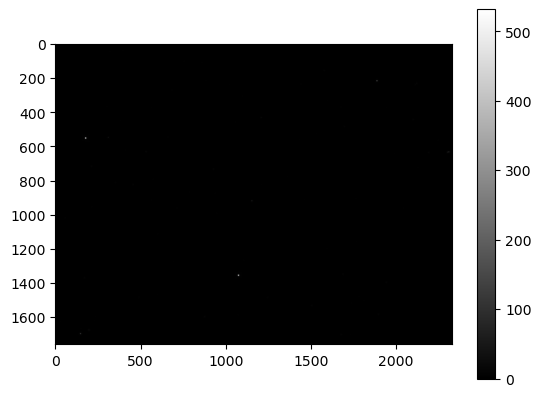

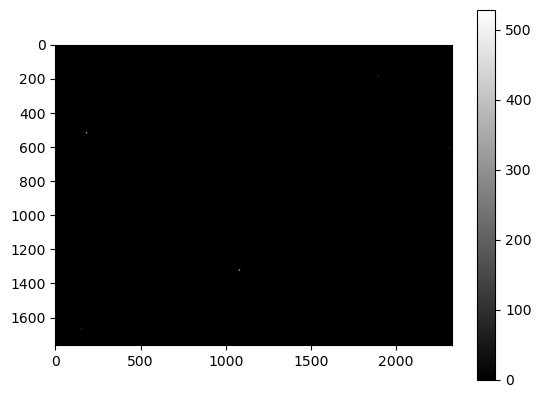

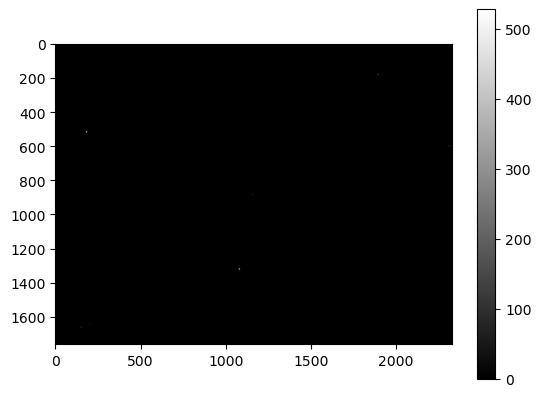

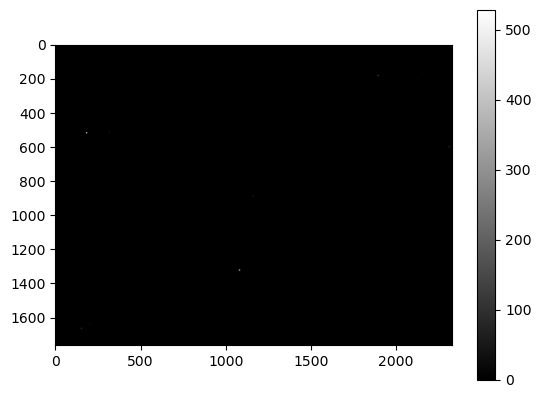

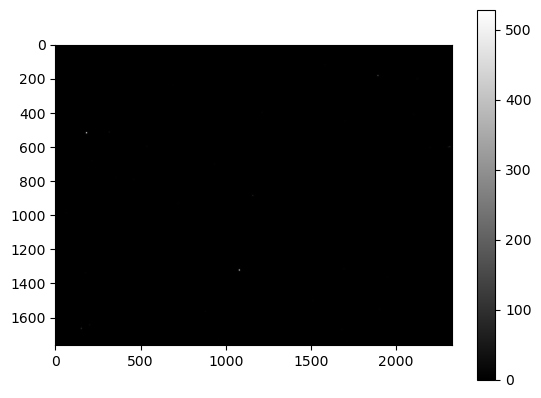

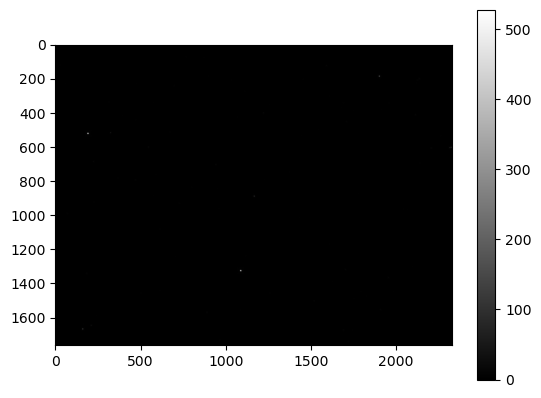

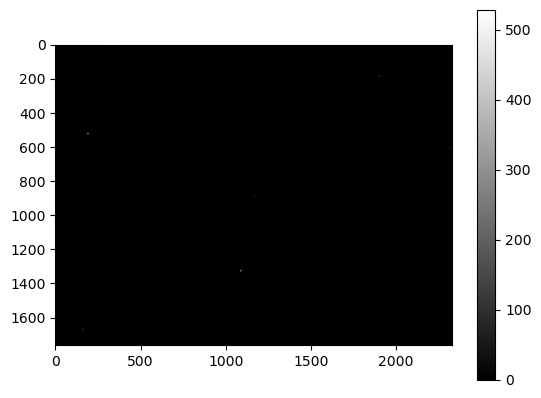

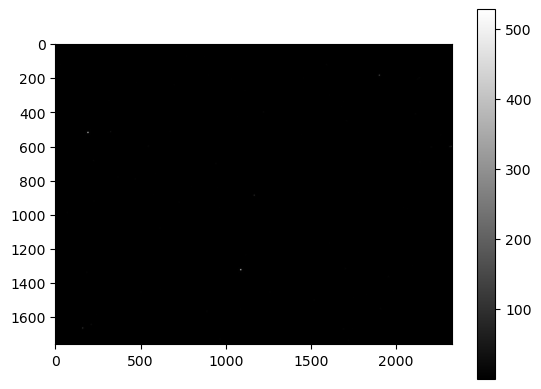

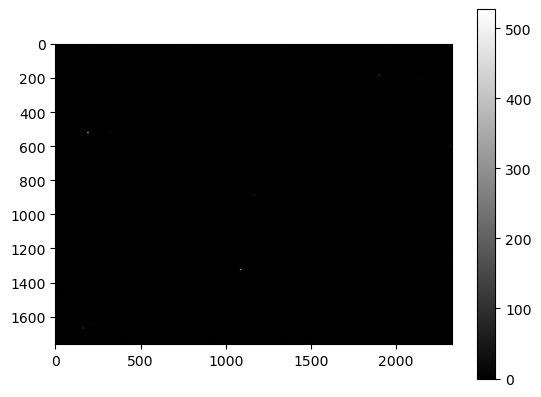

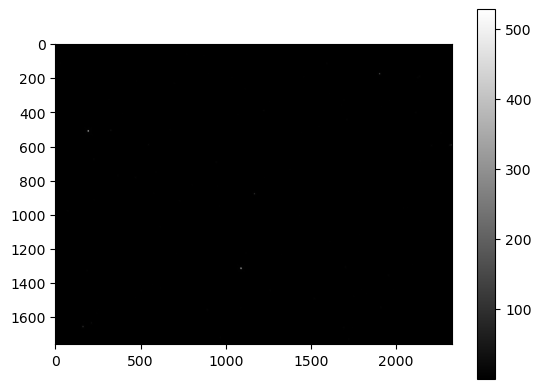

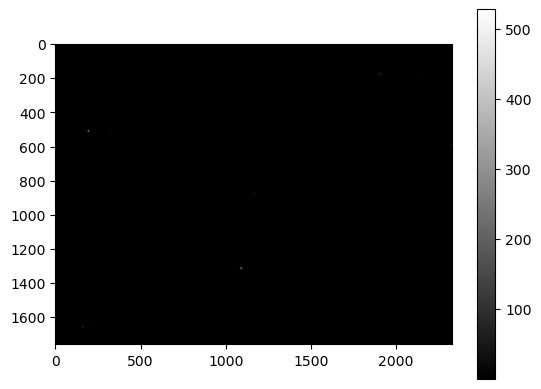

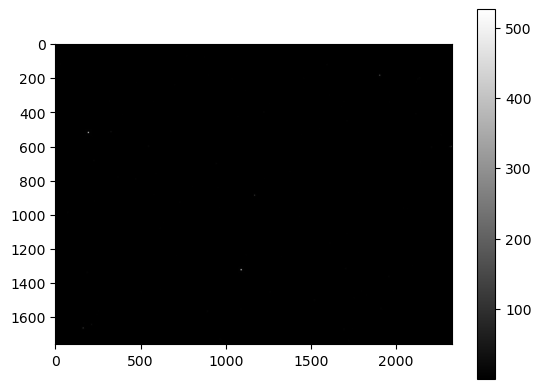

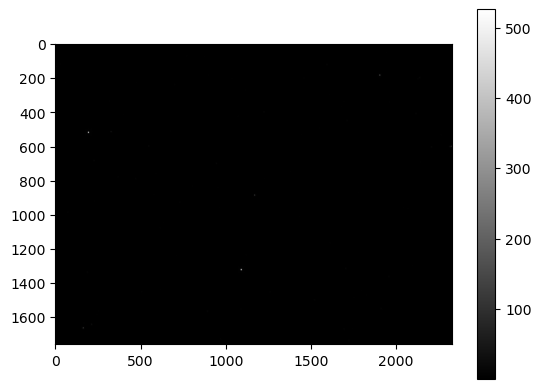

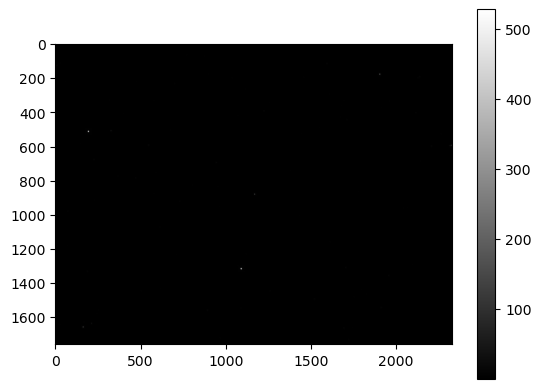

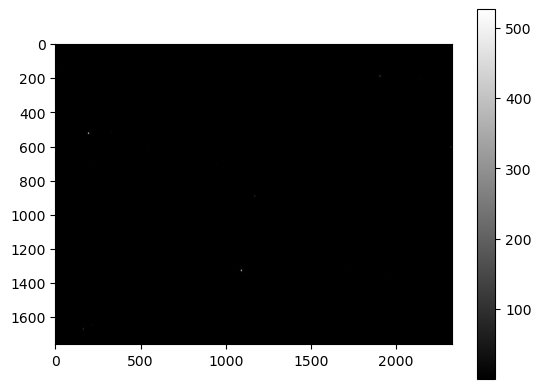

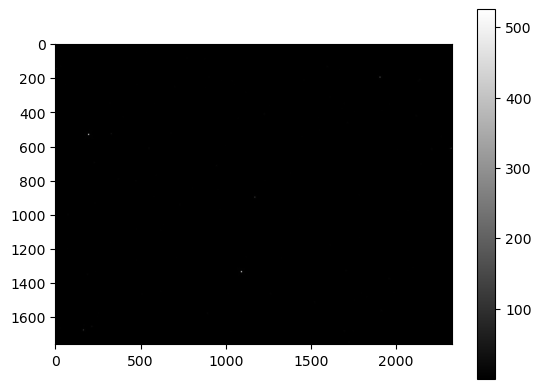

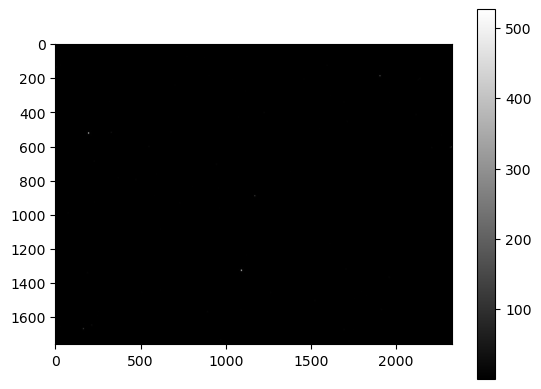

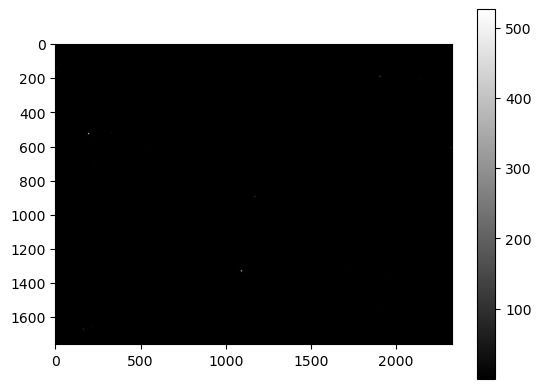

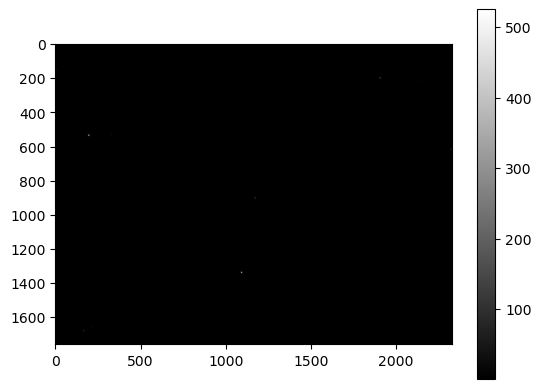

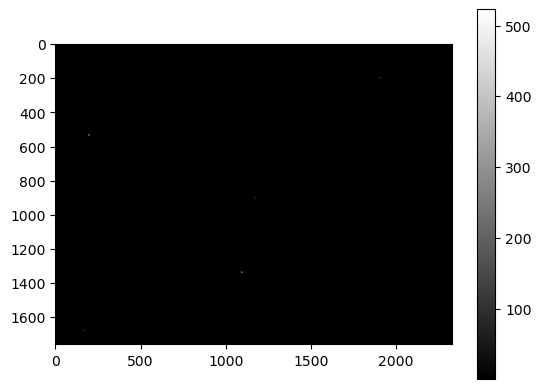

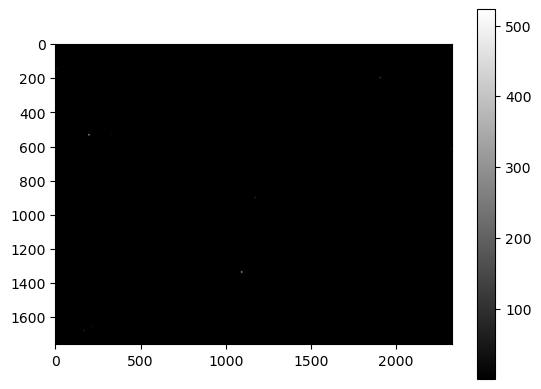

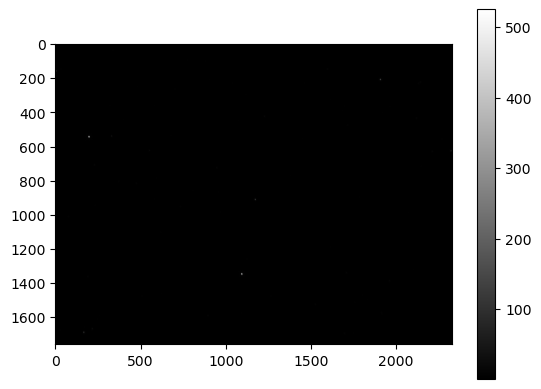

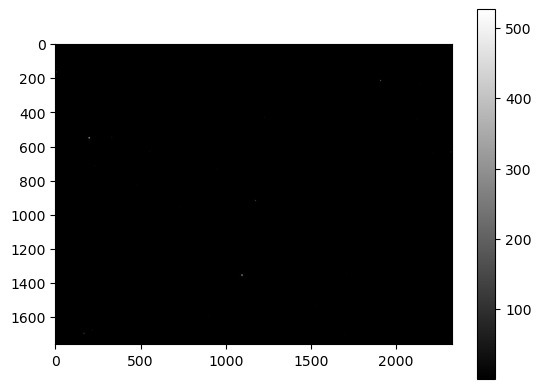

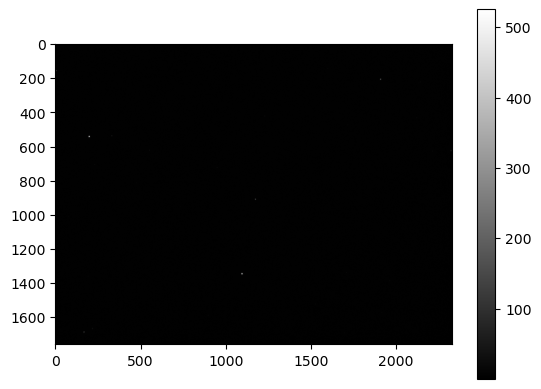

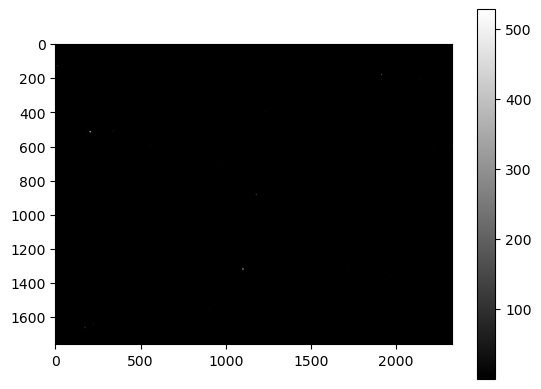

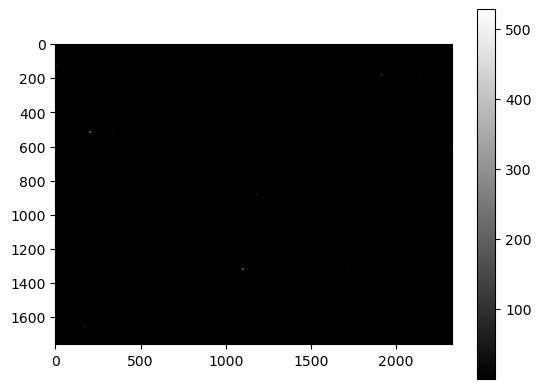

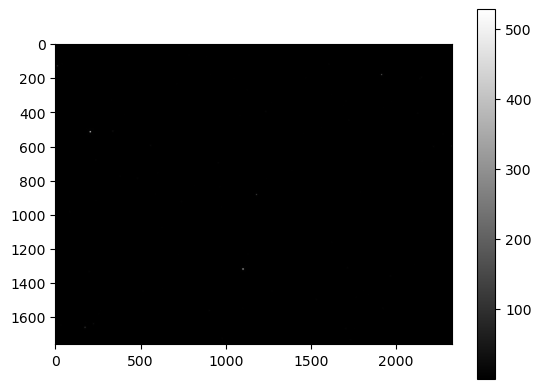

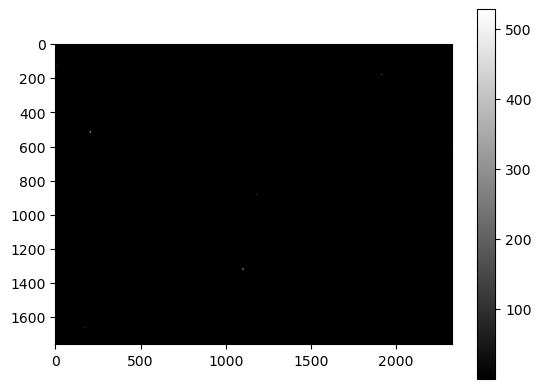

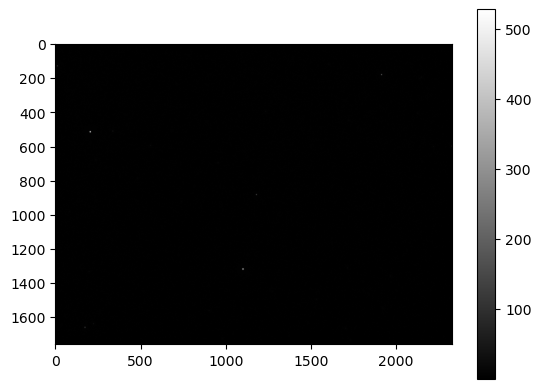

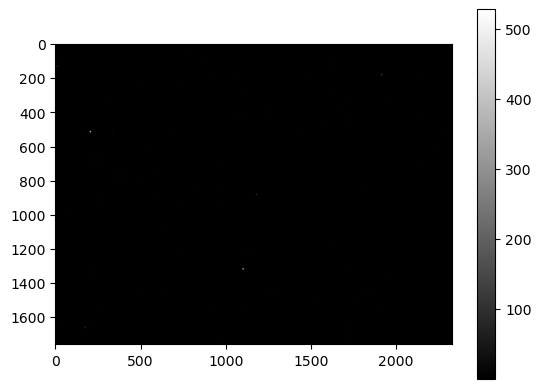

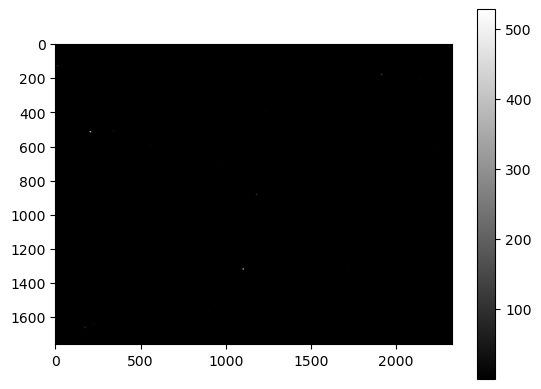

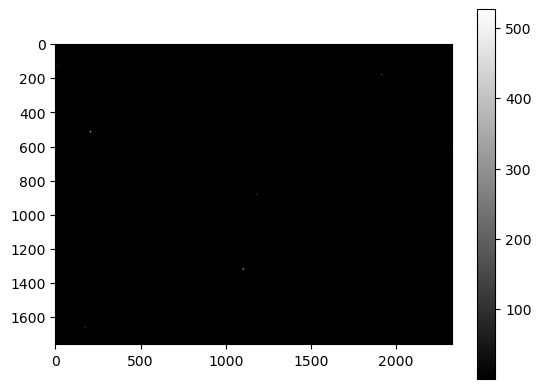

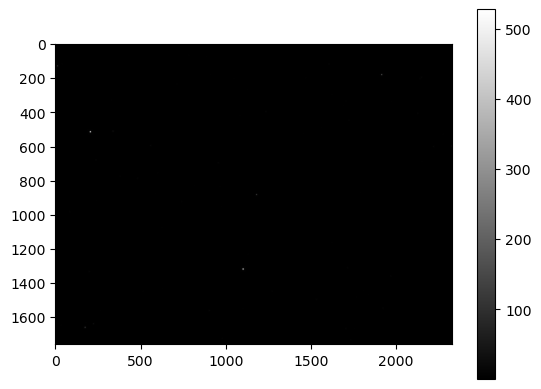

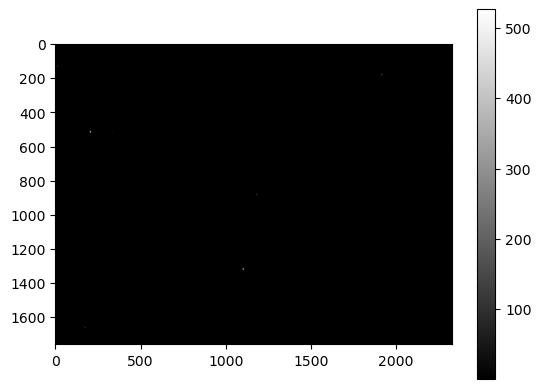

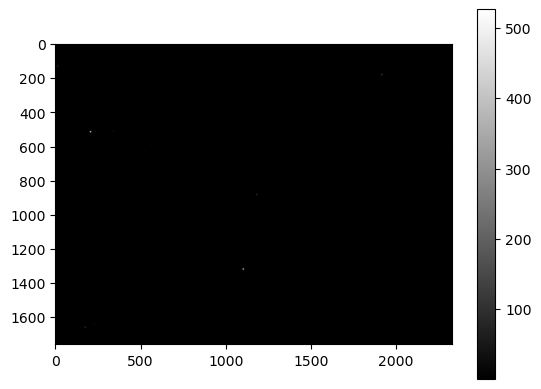

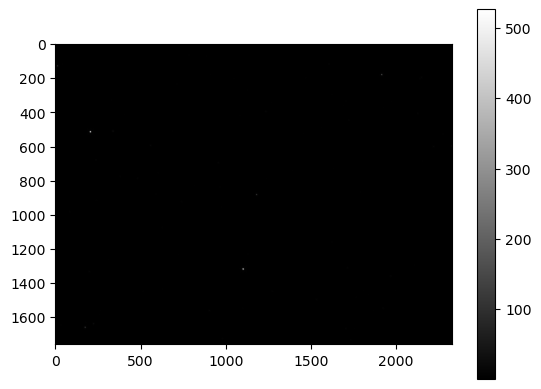

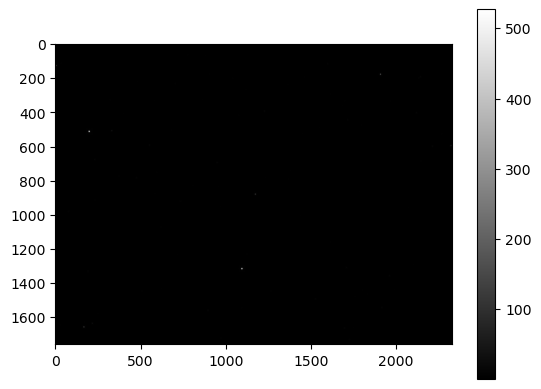

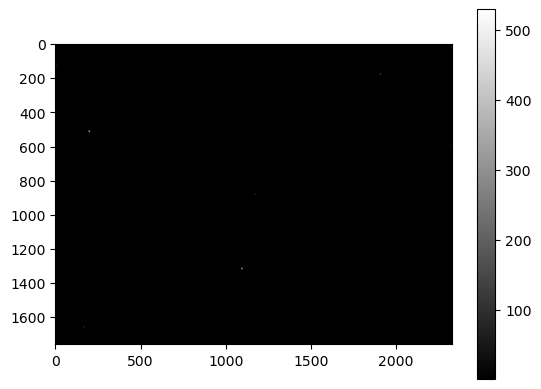

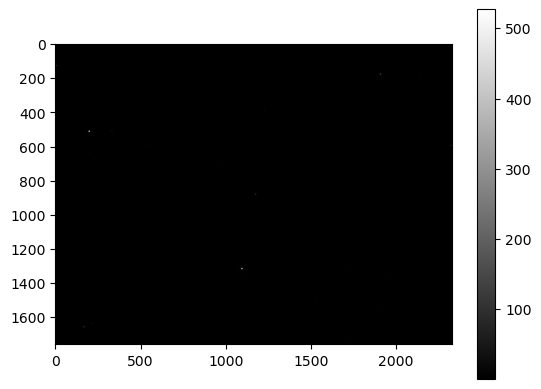

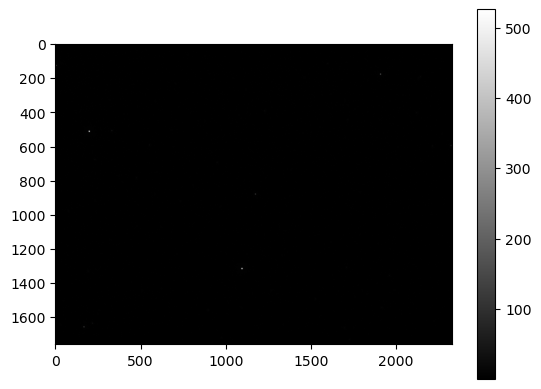

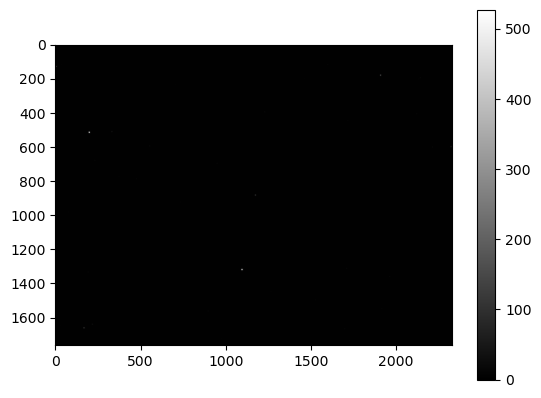

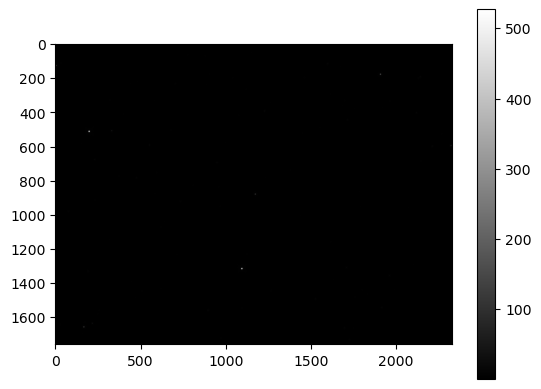

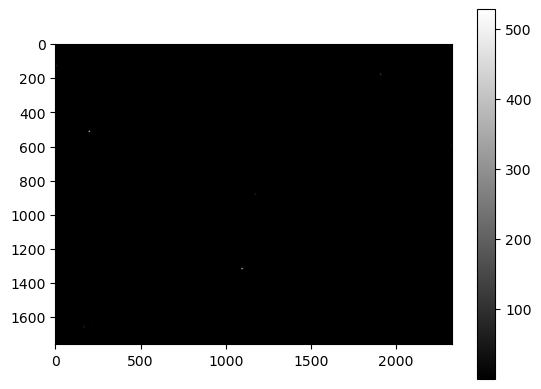

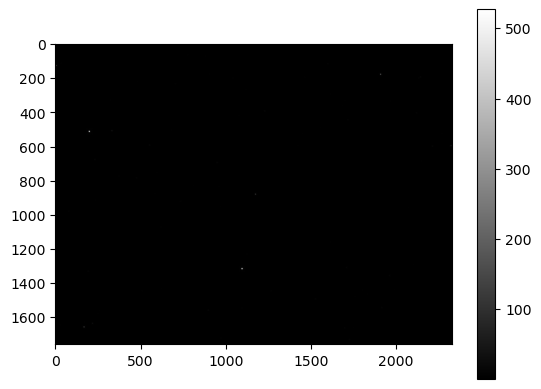

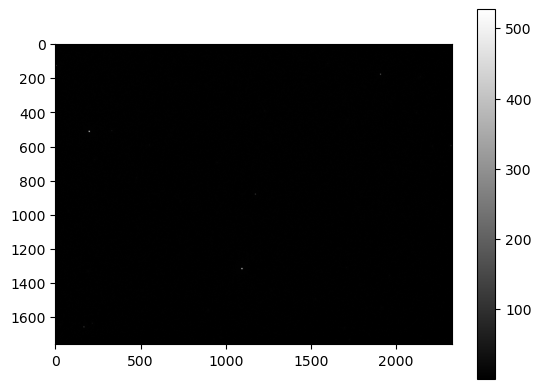

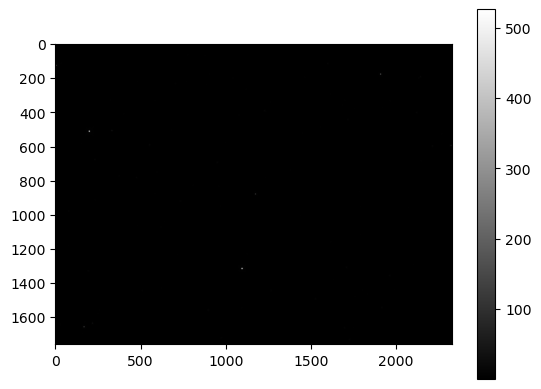

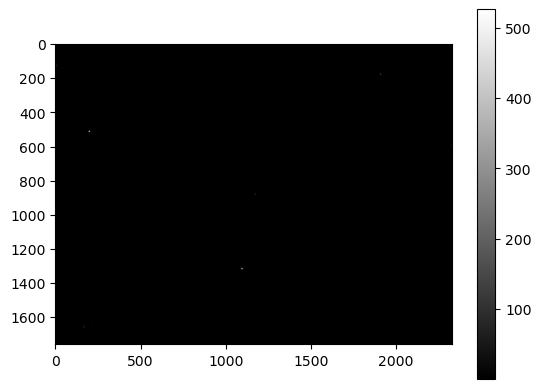

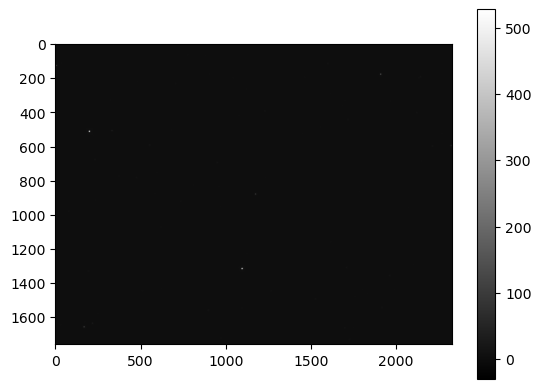

In [26]:
for image in image_list:
    hdul1 = fits.getdata(image)
    plt.figure()
    plt.imshow(hdul1, cmap='gray')
    plt.colorbar()

 id  xcenter   ycenter  aperture_sum
       pix       pix                
--- --------- --------- ------------
  1 173.09917 531.93133    26482.967
  2 1069.1722 1336.5265    26129.544
  3  1881.154 195.88703    9200.8226
  4  142.8193 1678.9172     6849.757
  5 2302.3557 612.93581    7239.4339
  6 1147.7071 899.78233    3848.1021
  7 2294.0111 614.72601    7238.0004
  8 305.92492 527.84559    2999.1452
  9 192.07588 1657.6793    2704.2749
 10 526.96942 611.91479    2111.9489
...       ...       ...          ...
 34 9.0360568 132.77121    1208.4625
 35   3.57288 1666.1008     988.6769
 36 947.54903 1743.0807    1460.7064
 37 2320.9535 1452.7881    1125.6057
 38 484.68549   1466.57    1516.8849
 39 313.54447 23.880368     1464.934
 40 1435.7824 214.50906    1506.8806
 41 1670.8483 350.58391    1502.4161
 42  208.6968 934.53586    1492.1058
 43 750.42294 82.461641    1478.1719
Length = 43 rows
 id  xcenter   ycenter  aperture_sum
       pix       pix                
--- --------- -------

 id  xcenter   ycenter  aperture_sum
       pix       pix                
--- --------- --------- ------------
  1 177.87829 540.05868    7013.9202
  2 1074.1598 1344.6326    6925.4126
  3 1886.0781 203.93643    6629.0433
  4 147.62495 1687.1669     6644.407
  5 2307.2651 621.10207    4635.6141
  6 2298.9326 622.85874    5414.0028
  7 1152.6121 907.88861    6539.6935
  8 310.71543 535.89047     6540.246
  9 196.88834 1665.9538    6666.9642
 10 531.84881 620.06239    6523.4648
...       ...       ...          ...
 31 683.46622 259.40181    6485.4915
 32  2325.398 1460.9711     3327.754
 33 13.753124 141.02354    4179.3637
 34 1244.6418 1474.5765    6449.1522
 35 952.38559 1751.3419    3698.0054
 36 1705.6251 1758.2901    3251.7057
 37 8.6615157 1674.1811    3791.6281
 38 1440.6386 222.74824    6520.1114
 39 489.01214 1474.8972    6513.4533
 40 755.13151   90.4378      6482.39
Length = 40 rows
59658.90438612271
 id  xcenter   ycenter  aperture_sum
       pix       pix                
---

 id  xcenter   ycenter  aperture_sum
       pix       pix                
--- --------- --------- ------------
  1 183.99458 514.15073    27038.146
  2  1080.201 1319.3546    26573.813
  3 1892.4937 178.23356    9889.1135
  4   153.639 1661.3531    7553.2065
  5 1158.9969 882.37998     4884.686
  6 2313.4973 595.53866    7747.9661
  7 316.78713  510.0253    3672.3702
  8 2305.2145 597.32611    7970.7559
  9 202.84701   1640.13    3379.3568
 10 537.97237 594.24193    2794.4066
...       ...       ...          ...
 26 1900.4534 1547.8378    2442.7843
 27 63.403048 982.58561    2299.5365
 28 2116.5375  200.5133    2952.4101
 29 719.54756 923.69217     2269.665
 30 358.56241 775.78516    2247.3889
 31 689.70914 233.48009    2207.5701
 32 1711.1468 1734.8087    2280.7657
 33 1251.1313  1448.955    2226.6331
 34 958.44065  1725.434    2177.7863
 35 495.48366 1449.1479    2161.7728
Length = 35 rows
 id  xcenter   ycenter  aperture_sum
       pix       pix                
--- --------- -------

 id  xcenter    ycenter  aperture_sum
       pix        pix                
--- ---------- --------- ------------
  1  192.73178 518.31144    10616.803
  2  1088.7751 1323.3708    10543.834
  3  1901.3328 182.24736    10210.005
  4  162.25691 1665.1477    10286.583
  5  1167.5409 886.22461     10175.21
  6 0.70011918 131.51335    5306.1305
  7  2322.3844 599.48673    5516.4963
  8  325.54117 514.02572    10135.164
  9   2314.112  601.3036     6315.683
 10  211.49083 1643.8759    10241.084
...        ...       ...          ...
 30  728.09655 927.46156    10061.121
 31  1719.8252 1738.9686    7079.0919
 32  367.18185  779.6221    10081.673
 33  698.41396 237.34016    10112.676
 34  1259.7634 1453.0174    10037.162
 35  967.12209 1729.3486    8435.5897
 36  28.628631 118.87197    10810.587
 37  504.01088 1453.0027    10085.822
 38  1455.8251 200.72137    10085.105
 39  770.08472 68.286399    10073.739
Length = 39 rows
59658.933233761694
 id  xcenter    ycenter  aperture_sum
       pix    

59658.93964881962
 id  xcenter   ycenter  aperture_sum
       pix       pix                
--- --------- --------- ------------
  1 195.01867 518.04296    25741.274
  2  1091.056 1323.1665    26834.095
  3 1903.3619 182.17668     11078.05
  4 2.0389389 131.41286    5273.7198
  5 1169.8141 886.06178    7816.9254
  6 164.61497 1664.8253    8525.5446
  7 2324.1895 599.36323    7016.5311
  8 327.80407 513.88995    4435.8552
  9 2315.9239 601.16508    7654.3587
 10 213.86207 1643.5959    4141.7805
...       ...       ...          ...
 30 1911.0878 1551.7256    3162.1085
 31  369.5211 779.51345    2951.8213
 32 700.70584 237.46873    2906.2666
 33 1721.8504 1738.6276    2962.6273
 34 1261.9114 1452.6732    2919.1263
 35 30.846617 118.81286    2870.5293
 36 969.37773 1729.2443    2864.2961
 37 25.606094  1652.015    2842.7363
 38  506.2528 1452.7857    2846.9977
 39  1457.986  200.8334    2849.3635
Length = 39 rows
 id  xcenter   ycenter  aperture_sum
       pix       pix                
---

C:\Users\micha\AppData\Local\Temp\ipykernel_11832\2018251314.py:20: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


59658.94448443269
 id  xcenter   ycenter  aperture_sum
       pix       pix                
--- --------- --------- ------------
  1 196.19783 522.45166    28259.903
  2 1092.2346 1327.6331    28281.277
  3  1904.626 186.86876    11241.441
  4 1170.9441 890.92242    8420.6519
  5 3.1959149 136.12175    5639.6243
  6 165.63852 1669.9368     8660.276
  7 2325.2494 604.11311    6714.3721
  8 328.92953 518.64238    4503.8289
  9 2317.1966 605.94616    7376.8973
 10 214.90167 1648.6865    4192.9537
...       ...       ...          ...
 25 1522.5875 1505.7338    3245.7732
 26 1694.5315 1675.5875    3289.0836
 27 2128.6281 209.18604    3766.7845
 28 75.584323  991.0853    3071.7531
 29 731.60433 932.27802    3072.3462
 30 1912.4266 1556.5417     3236.775
 31 370.61628 784.33783    3022.9627
 32 1723.1506 1743.5772    2856.9539
 33 701.80424 242.09438    2986.4747
 34 1263.0612 1457.5061    3024.5178
Length = 34 rows
 id  xcenter   ycenter  aperture_sum
       pix       pix                
---

59658.9524572799
 id  xcenter   ycenter  aperture_sum
       pix       pix                
--- --------- --------- ------------
  1 198.05014 532.57622     25823.82
  2 1094.0728 1337.6487    26672.398
  3 1906.4753 196.54324    11313.701
  4 1172.7715 900.41865    9114.5616
  5 5.0310898 145.91295    6067.9684
  6 167.53697 1679.2747    8738.9532
  7  2326.188 613.75042    5597.7436
  8 330.73129 528.20004    4694.5338
  9 2319.1711 615.65005    6211.4718
 10 216.80235 1658.1312    4373.2819
...       ...       ...          ...
 27 1914.3339 1566.1453    3409.4857
 28 77.332286 1000.8148    3241.1434
 29 733.37124 941.76375    3219.5186
 30 2130.6114  218.8514     3948.884
 31 372.39698 794.06207    3200.6513
 32 1725.0266 1753.1473    2281.6721
 33  703.6332  251.8385    3150.8161
 34 1264.9905 1467.1019    3145.4424
 35 33.925898 133.23418    3110.1355
 36 972.32372 1743.5946     2920.089
Length = 36 rows
 id  xcenter   ycenter  aperture_sum
       pix       pix                
--- 

 id  xcenter   ycenter  aperture_sum
       pix       pix                
--- --------- --------- ------------
  1 205.72162 513.94839    27375.309
  2 1101.6097 1319.1242    27418.788
  3 1914.0514 178.49394    11492.436
  4 1180.3221 882.14311    9215.7509
  5 12.912381 127.57053    6844.9176
  6 175.13261 1660.8875    8989.4293
  7 2325.9039 597.46002    3145.5995
  8 338.54467 509.88174    4865.1055
  9 224.40834 1639.7057    4536.0972
 10 559.58462 594.10663     3936.678
...       ...       ...          ...
 25 1703.7631 1666.6974     3603.053
 26 2138.0827 200.70146    4095.2759
 27 85.099053 982.32736    3406.5018
 28 1921.5995 1547.8247    3587.2568
 29 741.01547  923.3544    3370.9477
 30 380.18933 775.55318    3350.1792
 31 1732.4579 1734.7594    3365.4883
 32 711.32738 233.50513    3329.8419
 33 1272.4073 1448.7745    3348.3916
 34 979.94516 1725.3403    3280.3181
Length = 34 rows
 id  xcenter   ycenter  aperture_sum
       pix       pix                
--- --------- -------

 id  xcenter   ycenter  aperture_sum
       pix       pix                
--- --------- --------- ------------
  1 206.10993 514.16562    13367.542
  2 1101.8724 1319.4005    13227.057
  3 1914.3819 178.77393    12921.781
  4 1180.6564 882.34678    12848.341
  5  13.20035 127.80498    8254.2984
  6 175.36249 1661.3455     12967.89
  7 2326.0843 597.90255    6487.6587
  8 338.78168 510.07117    12873.233
  9 224.71458 1640.0791    12983.605
 10 559.84585 594.24955    12788.082
...       ...       ...          ...
 24 1704.1852 1667.1281    12653.598
 25 1532.2955 1497.2462    12750.139
 26 2138.5916 201.07465    12782.169
 27 1922.0137 1548.1934    12686.488
 28 85.378884 982.54306    12779.812
 29 1732.7948 1735.2215    9630.9709
 30  741.3086 923.59207    12736.323
 31  380.5044 775.77189    12800.369
 32 711.62723 233.78824    12772.657
 33 1272.7768  1448.972    12749.583
Length = 33 rows
59658.972938830964
 id  xcenter   ycenter  aperture_sum
       pix       pix                
--

 id  xcenter   ycenter  aperture_sum
       pix       pix                
--- --------- --------- ------------
  1 207.04879 514.31404    28561.128
  2 1102.7577 1319.4915    28469.479
  3 1915.2499  178.7385    11662.907
  4 1181.4216 882.45654    9051.6358
  5 176.21238 1661.1402    9191.2366
  6 14.133306  127.7597     7045.294
  7 339.68716 510.15137    5006.5997
  8 2326.3785 597.81833    2653.2484
  9 225.54291 1639.9391     4657.831
 10 560.69732 594.37039    4082.9594
...       ...       ...          ...
 23 1533.0836 1497.1922    3702.6078
 24 1723.1884 445.88479    3683.8296
 25 1704.8846 1667.1101    3745.5048
 26 2139.3344 201.09999    4248.5793
 27 86.261891    982.46    3551.3715
 28  1922.827 1548.4659      3712.72
 29 742.13173 923.68043    3541.0486
 30 381.37405 775.78752    3477.1823
 31 1733.5005 1735.1858     3509.065
 32 712.43785 233.74994    3464.7127
Length = 32 rows
 id  xcenter   ycenter  aperture_sum
       pix       pix                
--- --------- -------

 id  xcenter   ycenter  aperture_sum
       pix       pix                
--- --------- --------- ------------
  1 199.95477 511.26475    30350.689
  2 1095.5626  1316.414    29556.142
  3 1908.1009 175.96186    11802.252
  4 7.1139581 124.86121    6486.5407
  5 169.03363 1658.4381    9301.0103
  6 1174.1487 879.36782    8824.4159
  7 2320.8721  595.0681    5383.8948
  8 332.51865  507.0939    5098.1421
  9  218.3297  1637.153    4783.3408
 10 553.45657 591.25049    4144.4177
...       ...       ...          ...
 22 1708.5234 1309.6018    3917.1212
 23   1525.91 1494.2741    3788.6813
 24 477.19364 783.56651    3810.1863
 25 1697.7785  1664.368    3833.4731
 26 2132.2843   198.265    4324.9841
 27 1915.7524 1545.5158    3830.2876
 28 79.186788 979.62006    3666.1604
 29  1726.444 1732.4407    3597.0684
 30 734.91119 920.58063    3646.8708
 31 374.15143 772.85058    3592.2523
Length = 31 rows
 id  xcenter   ycenter  aperture_sum
       pix       pix                
--- --------- -------

59658.998089421075
 id  xcenter   ycenter  aperture_sum
       pix       pix                
--- --------- --------- ------------
  1 200.70538 511.95311    28162.997
  2 1096.3263 1317.1198    28224.378
  3 1908.7958 176.76391    11785.878
  4 7.9093581 125.52937    6630.5732
  5 169.82821 1658.9683    9273.1876
  6 1174.8843 880.20131    8599.3928
  7 2321.4874 595.87841    5024.4093
  8 333.36451 507.78446     5123.562
  9 219.11584 1637.6535    4828.2563
 10 554.23362 592.02756    4190.1033
...       ...       ...          ...
 23 1716.6793 443.72809    3831.9981
 24 1698.3953 1665.0848    3887.2812
 25 2132.9412 199.01118    4392.0938
 26 1526.5372 1495.1302    3832.4353
 27 1916.3767  1546.171    3841.7932
 28  79.86999 980.19493    3691.9093
 29 735.72995 921.36807    3667.5511
 30 374.95913 773.40736    3645.0952
 31 1727.1096 1733.1201    3667.9835
 32 706.07203 231.60068     3601.197
Length = 32 rows
 id  xcenter   ycenter  aperture_sum
       pix       pix                
--

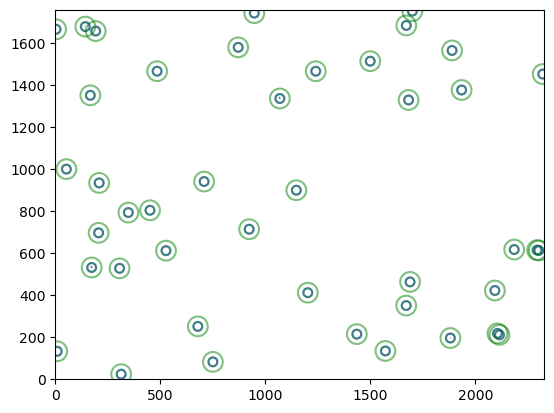

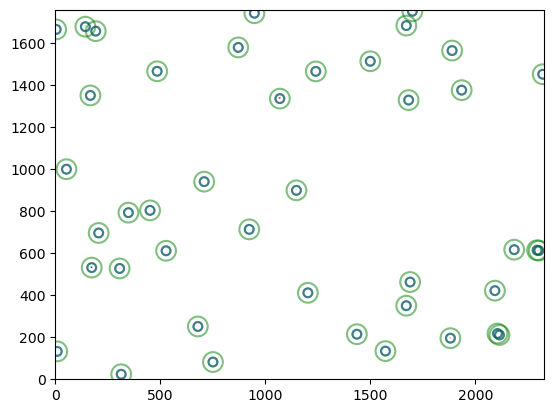

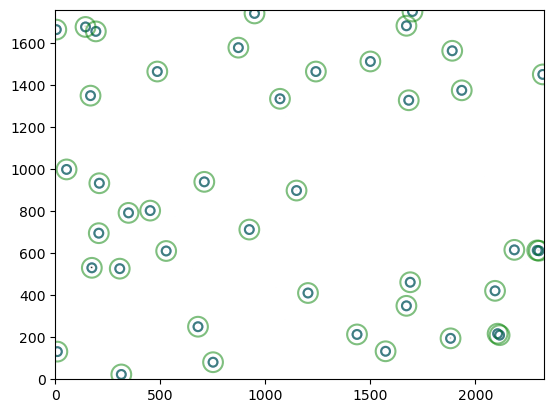

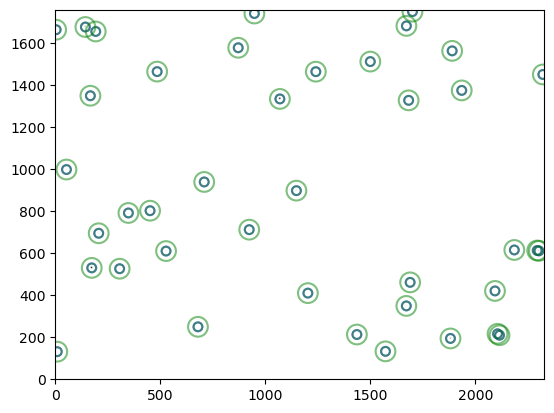

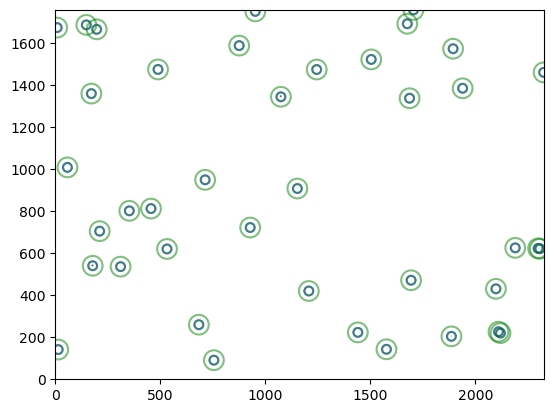

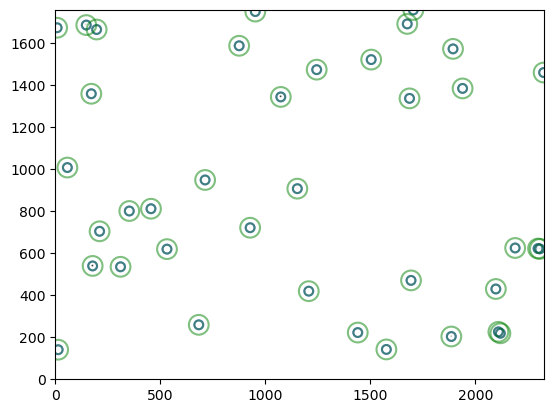

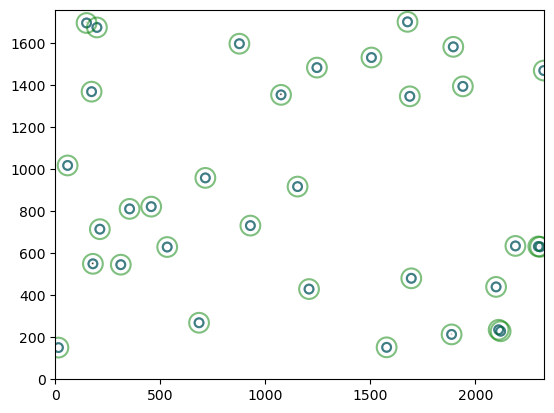

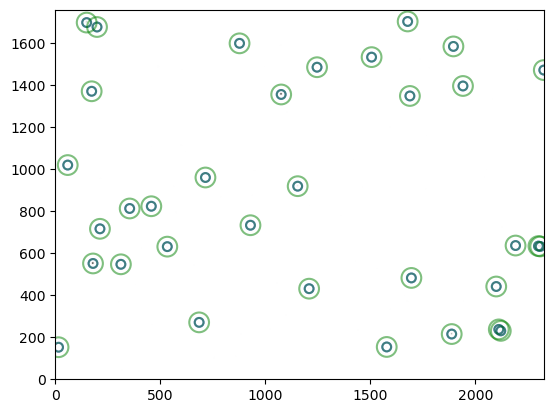

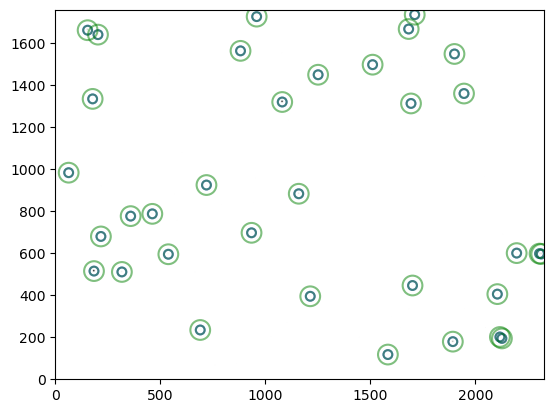

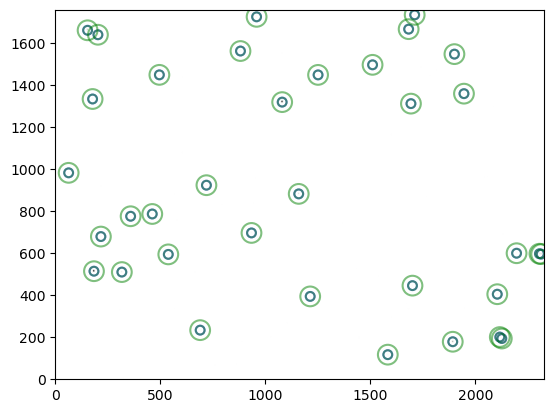

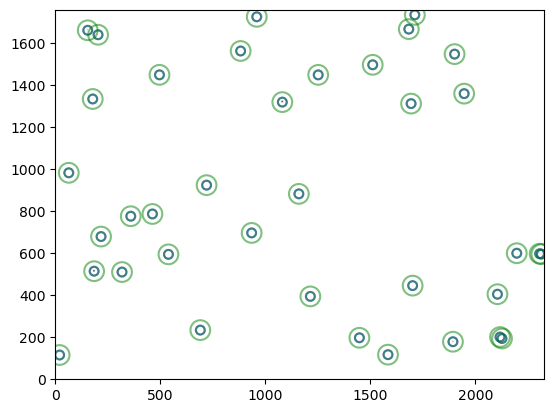

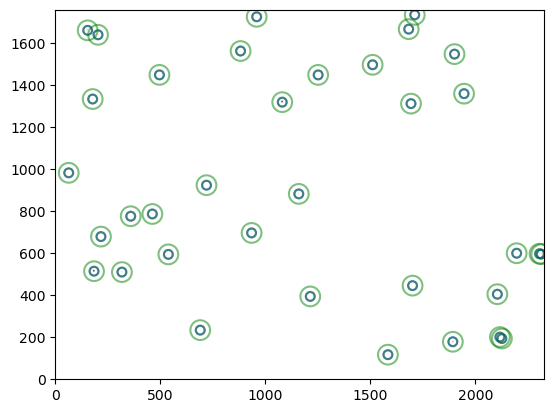

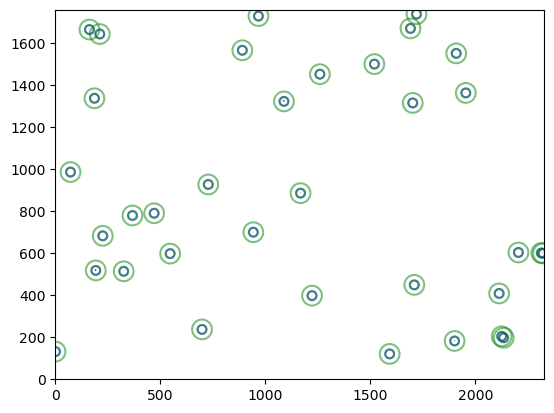

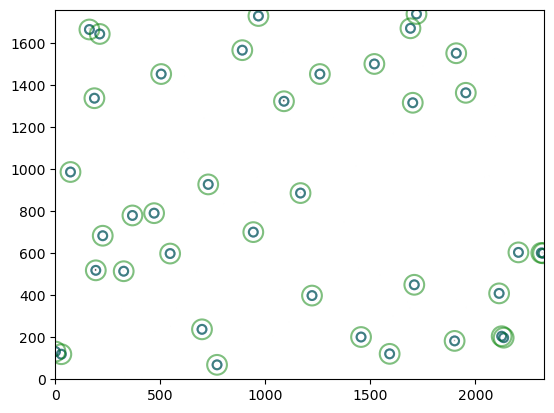

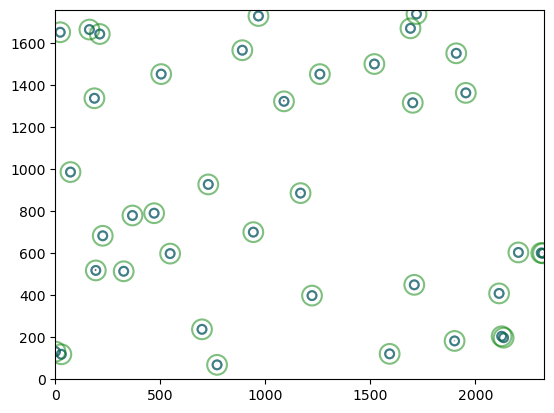

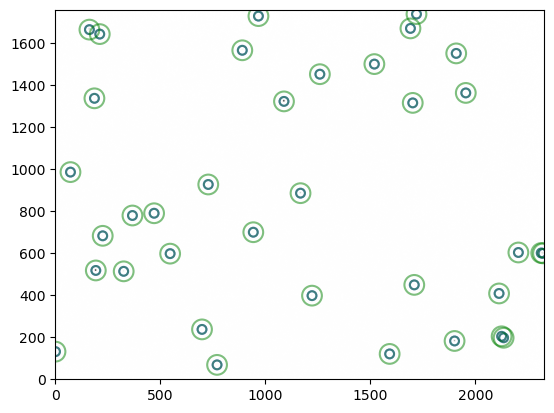

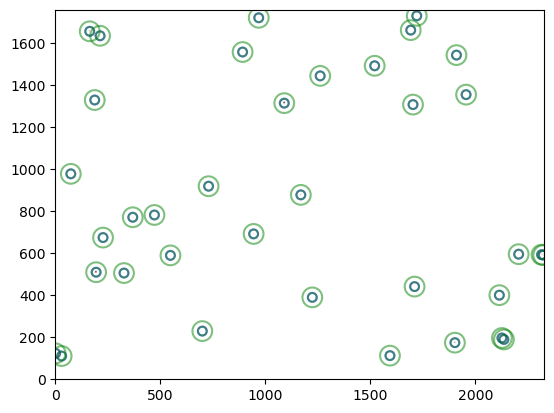

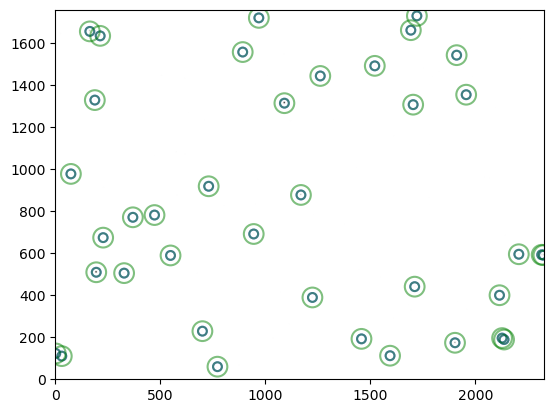

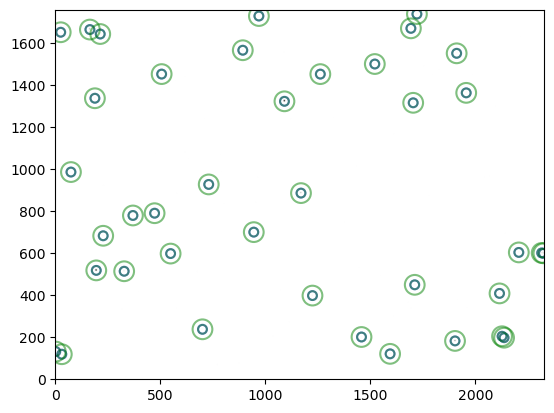

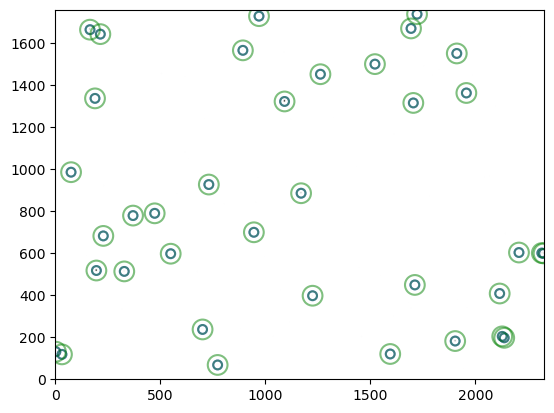

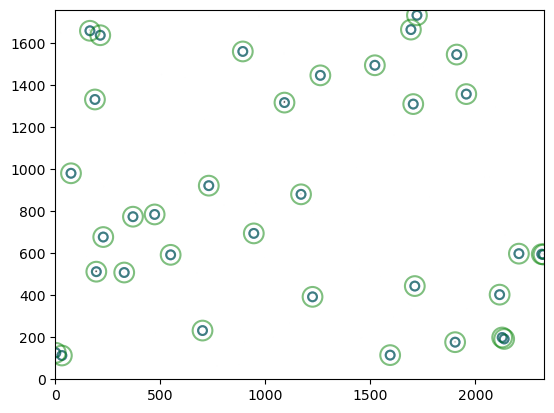

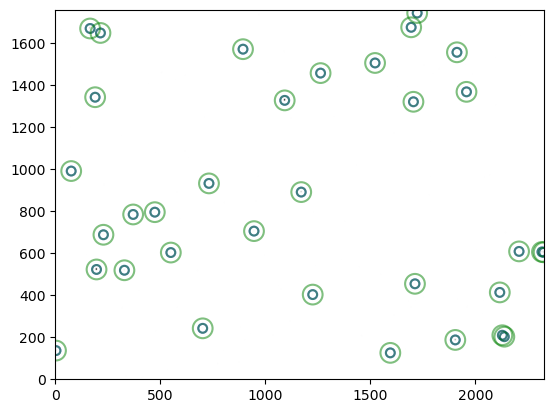

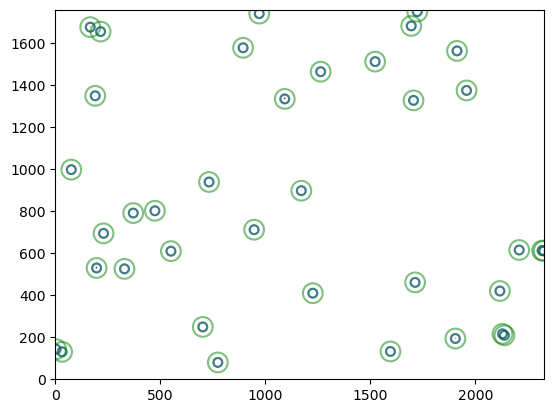

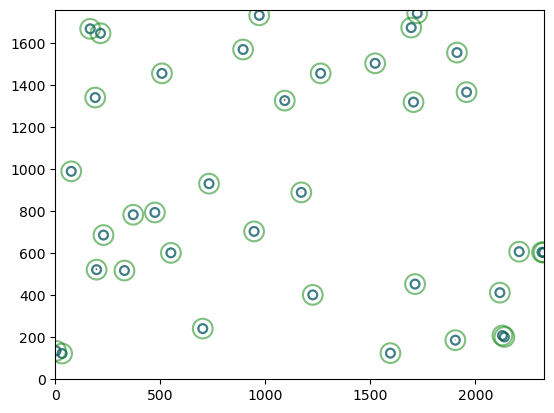

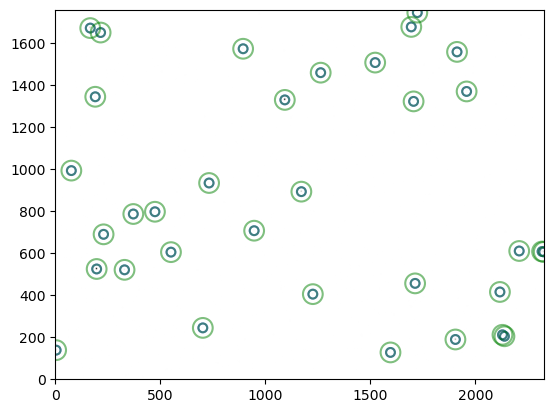

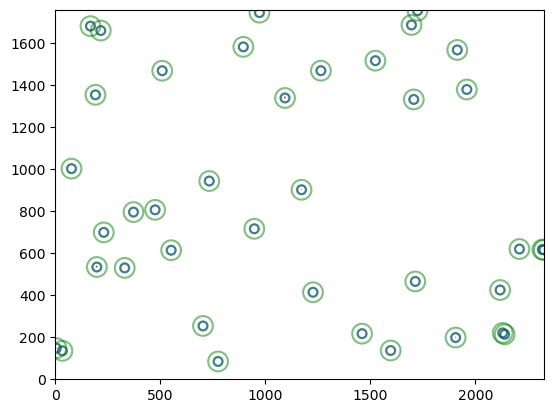

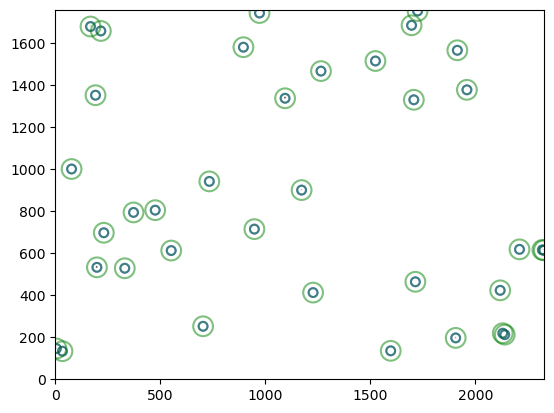

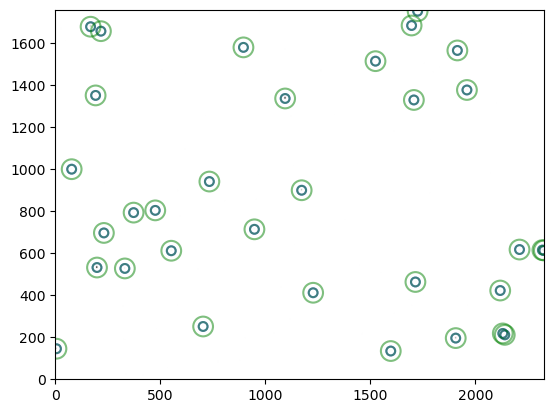

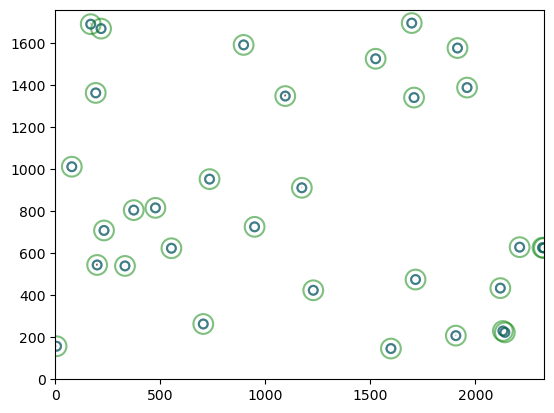

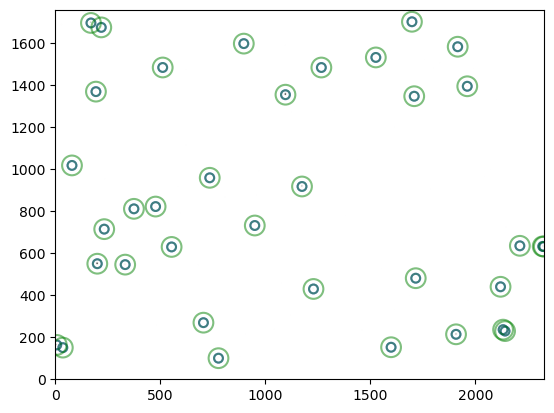

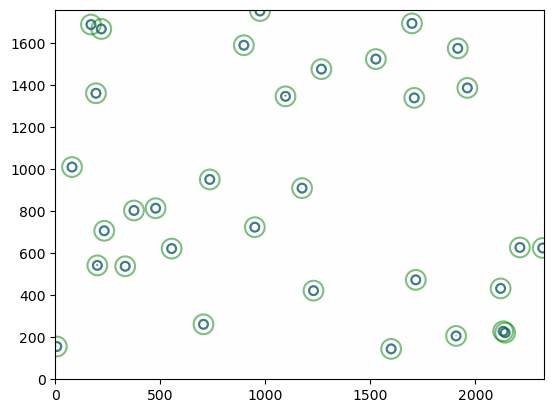

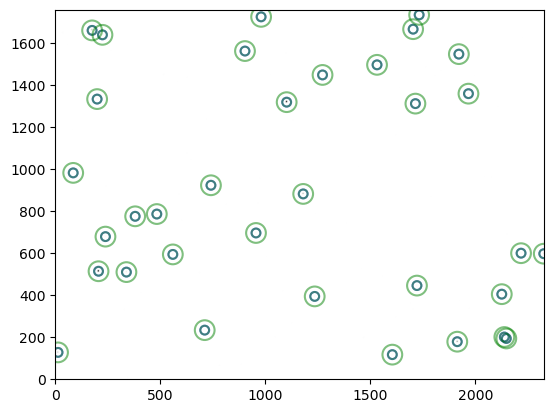

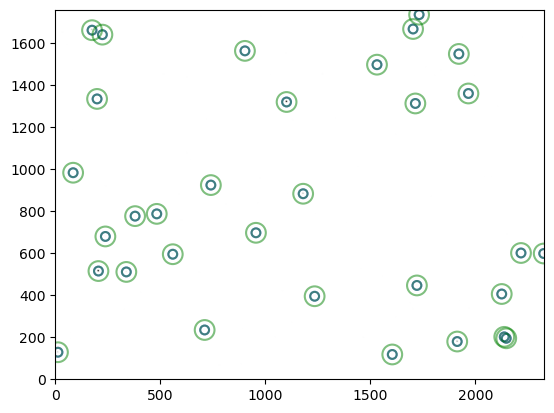

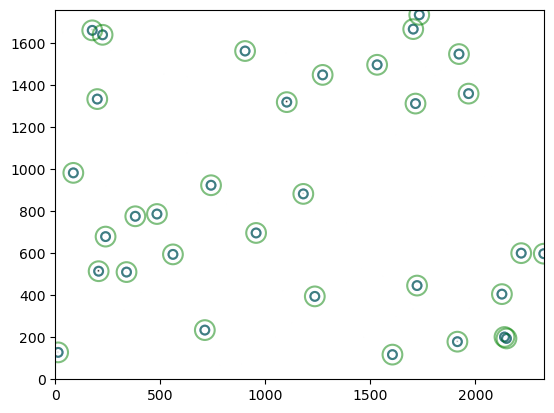

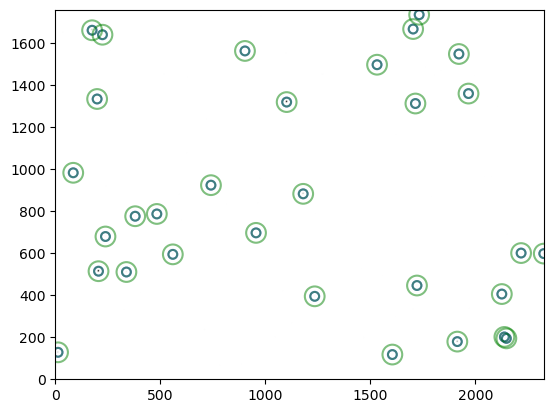

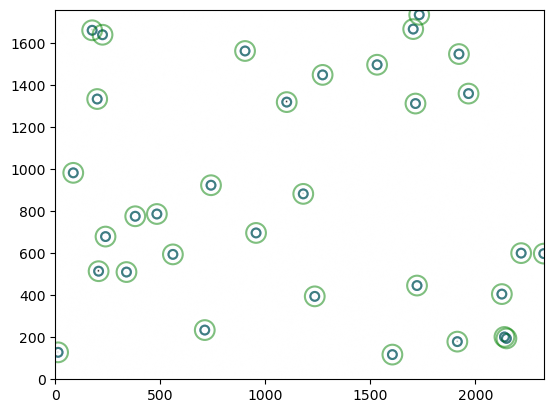

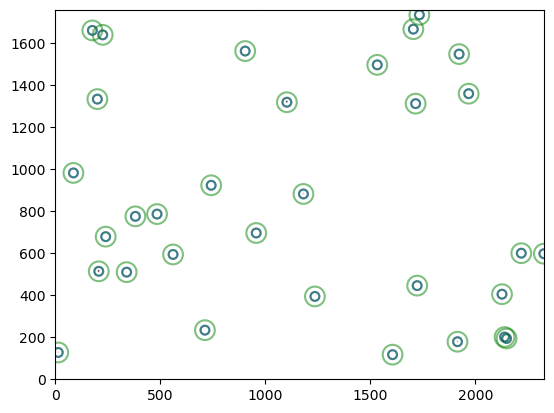

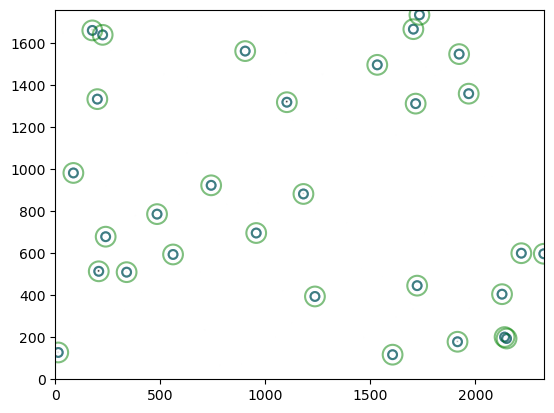

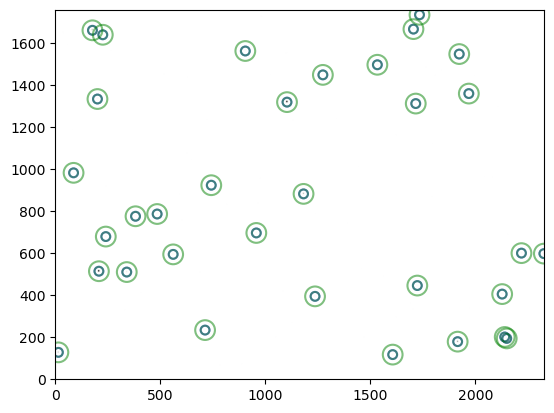

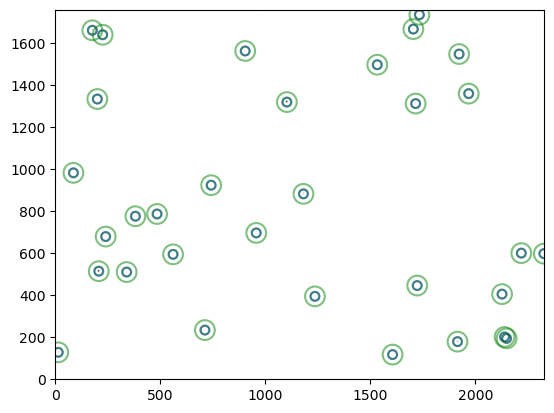

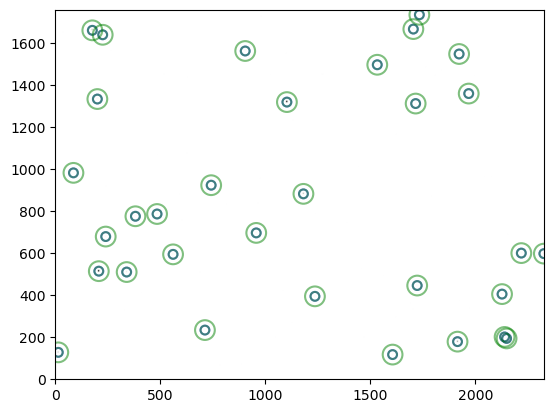

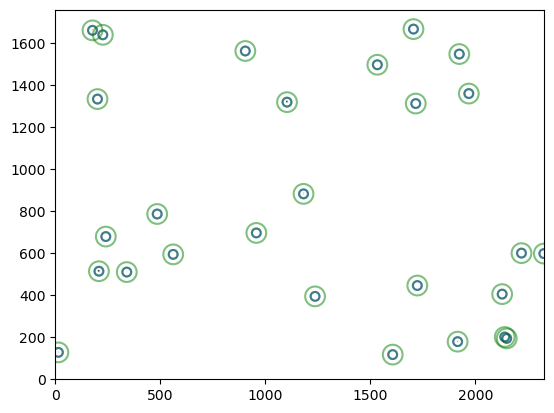

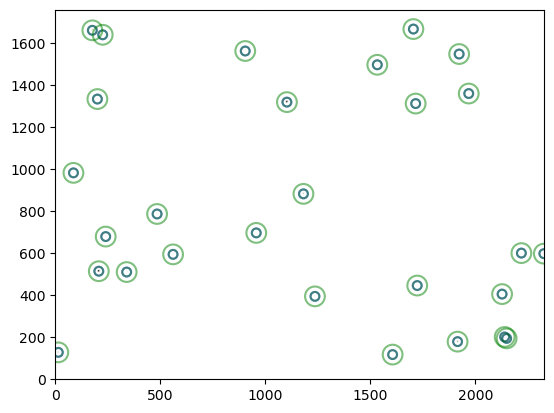

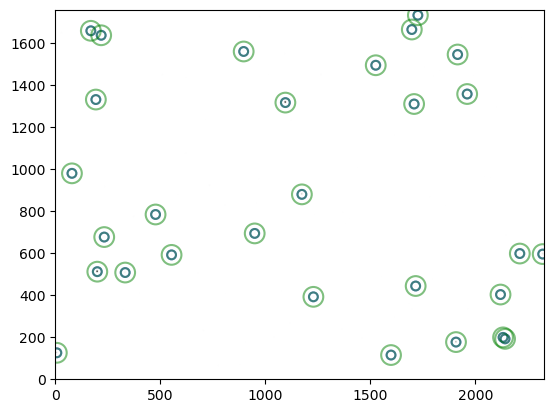

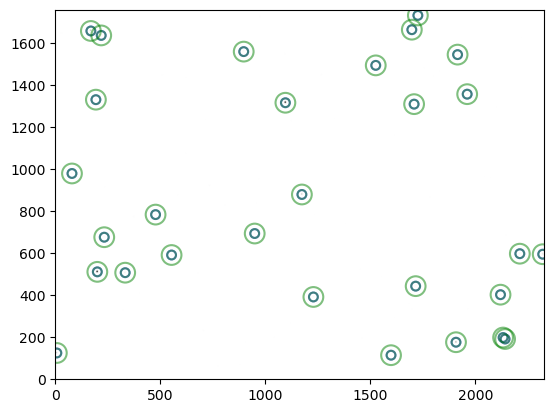

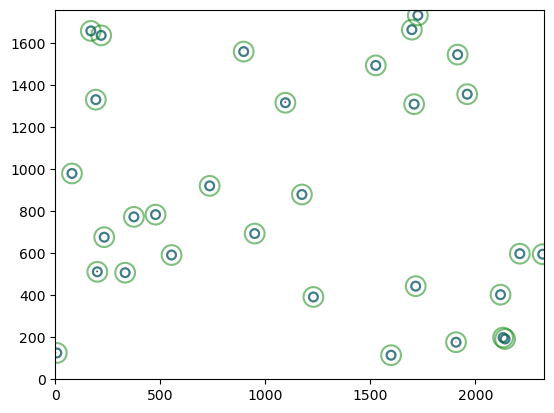

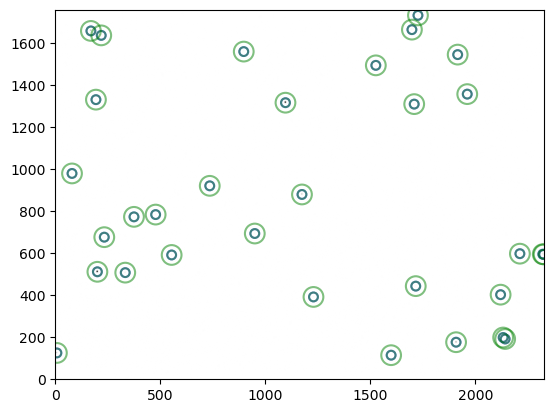

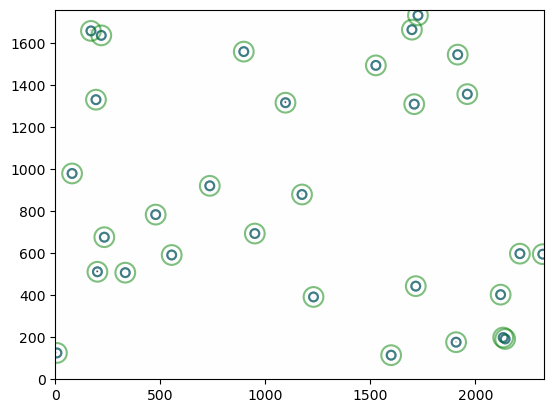

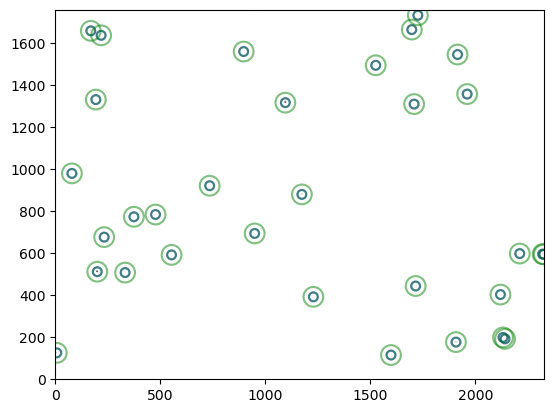

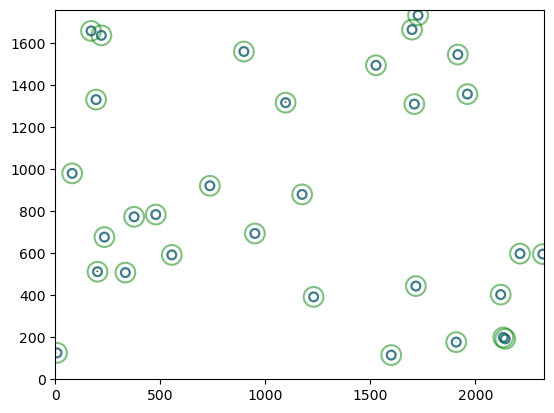

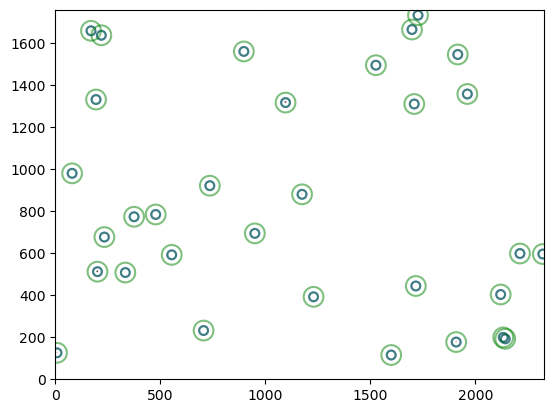

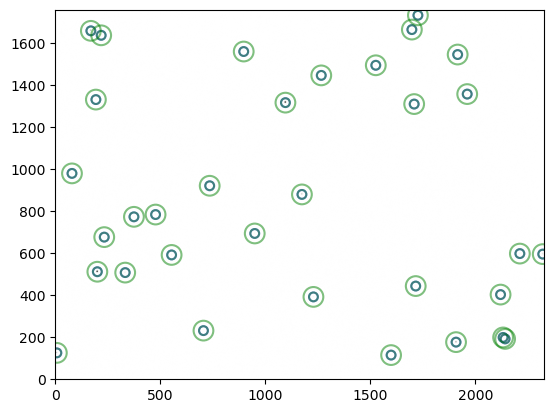

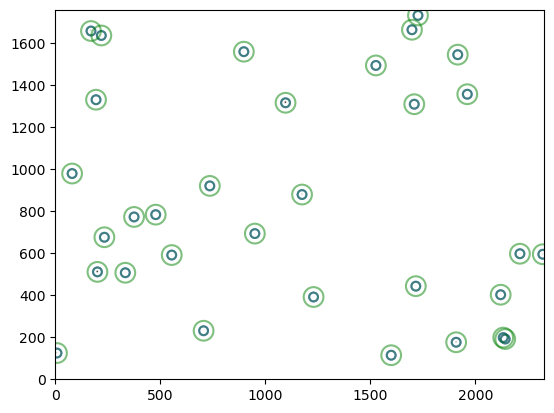

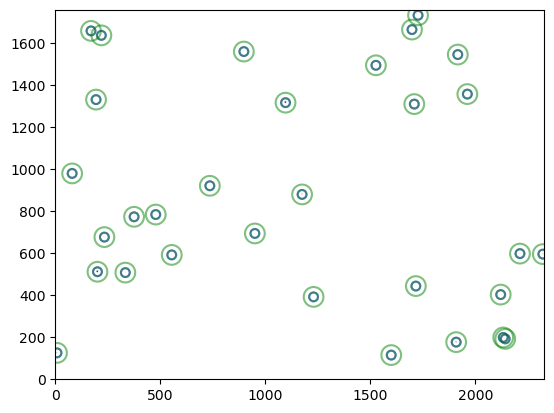

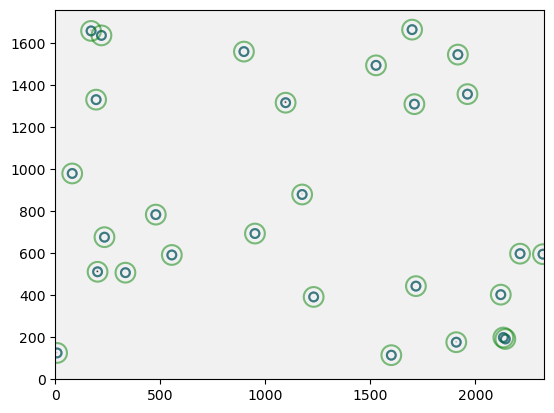

In [43]:
from photutils.detection import DAOStarFinder
for image in image_list:
    hdul1 = fits.getdata(image)
    daofind = DAOStarFinder(fwhm=6,threshold = 5*np.median(hdul1),brightest=100)
    df_out = daofind(hdul1 - np.median(hdul1))
    
    #Converting the table of data to a dataframe:
    stars_found = df_out.to_pandas()
    
    #Circular apertures will be drawn around all of the stars:
    positions = np.transpose((stars_found['xcentroid'], stars_found['ycentroid']))  
    apertures = CircularAperture(positions, r = 21)  
    phot_table = aperture_photometry(hdul1, apertures)  
    for col in phot_table.colnames:  
        phot_table[col].info.format = '%.8g'  # for consistent table output
    print(phot_table)
    
    #Showing in the image:
    import matplotlib.pyplot as plt
    plt.figure()
    plt.imshow(hdul1, cmap='gray_r', origin='lower')
    apertures.plot(color='blue', lw=1.5, alpha=0.5)
    
    #Finding the stats for the apertures:
    CIRC_stats = ApertureStats(hdul1, apertures)
    df_star_stats = pd.DataFrame()
    df_star_stats['Area of circular aperture'] = CIRC_stats.sum_aper_area.value
    df_star_stats['Sum of circular aperture'] = CIRC_stats.sum
    df_star_stats
    
    #Circular annuli will be drawn around all of the stars:
    positions = np.transpose((stars_found['xcentroid'], stars_found['ycentroid']))  
    annuli = CircularAnnulus(positions, r_in = 21, r_out = 21*np.sqrt(5))  
    phot_table_2 = aperture_photometry(hdul1, annuli)  
    for col in phot_table_2.colnames:  
        phot_table_2[col].info.format = '%.8g'  # for consistent table output
    print(phot_table_2)
    
    #Showing in the image:
    import matplotlib.pyplot as plt
    plt.imshow(hdul1, cmap='gray_r', origin='lower')
    annuli.plot(color='green', lw=1.5, alpha=0.5)
    
    #Finding the required annulus stats:
    annulus_stats = ApertureStats(hdul1, annuli)
    df_star_stats['Median of annulus'] = annulus_stats.median
    df_star_stats['id'] = annulus_stats.id
    df_star_stats
    
    #Calculating the star counts:
    def star_counts():
        Ct = df_star_stats['Sum of circular aperture']
        Ca = df_star_stats['Area of circular aperture']
        P = df_star_stats['Median of annulus']
        star_counts = Ct - (P*Ca)
        return star_counts
    df_star_stats['star counts'] = star_counts ()
    df_star_stats
    
    #Collect all necessary data into one dataframe and save to a .csv file:
    hdul2 = fits.open(image)
    date = hdul2[0].header.get('DATE-OBS')
    t = Time(date)
    t.format = 'jd'
    MJD = t.jd - 2400000.5
    print(MJD)
    df_star_stats['MJD'] = MJD
    df_star_stats['xcentroid'] = stars_found['xcentroid'] 
    df_star_stats['ycentroid'] = stars_found['ycentroid']
    df_star_stats    
    df_star_stats.to_csv(image+'star_stats_stuff.csv')